## Compute stats and errors of the models on helsinki 

In [14]:
import numpy as np
from src.data.components.helsinki import HelsinkiProminenceExtractor
import os
import json

In [49]:
root_dir = "/Users/lukas/Desktop/projects/MIT/prosody/prosody/repositories/helsinki-prosody/data"
save_path = "/Users/lukas/Desktop/projects/MIT/prosody/prosody/repositories/helsinki-prosody/data/precomputed/"
filename = "train_360.txt"

In [50]:
helsinki_extractor = HelsinkiProminenceExtractor(
    root_dir, filename, lowercase=True, remove_punctuation=False
)

texts = helsinki_extractor.get_all_texts()
cont_prominences = helsinki_extractor.get_all_real_prominence()
discrete_prominences = helsinki_extractor.get_all_discrete_prominence()

print(
    f"Number of texts: {len(texts)}, number of prominence values: {len(cont_prominences)}"
)

texts[:3]

Number of texts: 116263, number of prominence values: 116263


["for man of you your characteristic race here may he hardy sweet gigantic grow here tower proportionate to nature here climb the vast pure spaces unconfined uncheck'd by wall or roof here laugh with storm or sun here joy here patiently inure here heed himself unfold himself not others' formulas heed here fill his time to duly fall to aid last to disappear to serve",
 "tom the piper's son",
 "tom tom the piper's son stole a pig and away he run the pig was eat and tom was beat and tom ran crying down the street"]

In [51]:
# run this cell if we don't want to process the texts
clean_texts = texts
clean_texts_removed_punctuation = texts

print(clean_texts[:3])

["for man of you your characteristic race here may he hardy sweet gigantic grow here tower proportionate to nature here climb the vast pure spaces unconfined uncheck'd by wall or roof here laugh with storm or sun here joy here patiently inure here heed himself unfold himself not others' formulas heed here fill his time to duly fall to aid last to disappear to serve", "tom the piper's son", "tom tom the piper's son stole a pig and away he run the pig was eat and tom was beat and tom ran crying down the street"]


In [52]:
from src.utils.text_processing import (
    python_lowercase_remove_punctuation,
    python_remove_punctuation,
)

clean_texts = python_lowercase_remove_punctuation(texts)
print(clean_texts[:3])

clean_texts_removed_punctuation = python_remove_punctuation(texts)

len(clean_texts_removed_punctuation), len(clean_texts)

['for man of you your characteristic race here may he hardy sweet gigantic grow here tower proportionate to nature here climb the vast pure spaces unconfined uncheckd by wall or roof here laugh with storm or sun here joy here patiently inure here heed himself unfold himself not others formulas heed here fill his time to duly fall to aid last to disappear to serve', 'tom the pipers son', 'tom tom the pipers son stole a pig and away he run the pig was eat and tom was beat and tom ran crying down the street']


(116263, 116263)

In [53]:
# split into single words and remove empty strings
words = [el for text in clean_texts for el in text.split(" ")]
words_no_punctuation = [
    el for text in clean_texts_removed_punctuation for el in text.split(" ")
]
len(words), len(words_no_punctuation)

(2075946, 2075946)

In [54]:
# flatten labels
cont_prominences = [item for sublist in cont_prominences for item in sublist]
len(cont_prominences)

2075946

In [55]:
max_prominence = max(cont_prominences)
min_prominence = min(cont_prominences)
print(f"Max prominence: {max_prominence}, Min prominence: {min_prominence}")
global_std_dev = np.std(cont_prominences)
global_avg_prominence = np.mean(cont_prominences)
print(f"Average prominence: {global_avg_prominence}, Std deviation: {global_std_dev}")

# predict random value between max(0, avg - 3*std) and min(1, avg + 3*std) for each word
lower = max(0, global_avg_prominence - 3 * global_std_dev)
upper = min(max_prominence, global_avg_prominence + 3 * global_std_dev)
print(f"Range for random prominence: [{lower}, {upper}]")
random_prominence = np.random.choice(
    np.arange(lower, upper, 0.01), len(cont_prominences)
)


# compute mse
mse = np.mean((cont_prominences - random_prominence) ** 2)
print(f"MSE: {mse}")

Max prominence: 6.606, Min prominence: 0.0
Average prominence: 0.7272557007744903, Std deviation: 0.7953191125178041
Range for random prominence: [0, 3.1132130383279026]
MSE: 2.1302531017343416


In [56]:
# go over all words and collect their labels
word_to_prominence = {}
for word, prominence in zip(words, cont_prominences):
    if word not in word_to_prominence:
        word_to_prominence[word] = []
    word_to_prominence[word].append(prominence)

word_to_prominence_no_punctuation = {}
for word, prominence in zip(words_no_punctuation, cont_prominences):
    if word not in word_to_prominence_no_punctuation:
        word_to_prominence_no_punctuation[word] = []
    word_to_prominence_no_punctuation[word].append(prominence)

# compute mean prominence for each word
word_to_mean_prominence = {}
word_to_std_prominence = {}
word_to_min_prominence = {}
word_to_max_prominence = {}
for word, prominences in word_to_prominence.items():
    word_to_mean_prominence[word] = np.mean(prominences)
    word_to_std_prominence[word] = np.std(prominences)
    word_to_min_prominence[word] = np.min(prominences)
    word_to_max_prominence[word] = np.max(prominences)


word_to_mean_prominence_no_punctuation = {}
for word, prominences in word_to_prominence_no_punctuation.items():
    word_to_mean_prominence_no_punctuation[word] = np.mean(prominences)

#### Store the stats of the words for further use

In [57]:
# create a dictionary that has as key all words, and as value a dict with the number of occurences, mean prominence, std prominence, min prominence, max prominence
word_to_stats = {}
for word, prominences in word_to_prominence.items():
    word_to_stats[word] = {
        "count": len(prominences),
        "mean": np.mean(prominences),
        "std": np.std(prominences),
        "min": np.min(prominences),
        "max": np.max(prominences),
    }

# add global mean as "$global" value (default, out-of-vocabulary value)
word_to_stats["$global$"] = {
    "count": len(cont_prominences),
    "mean": global_avg_prominence,
    "std": global_std_dev,
    "min": min_prominence,
    "max": max_prominence,
}

# store json file
# with open(os.path.join("word_to_stats_uncased.json"), "w") as f:
#     json.dump(word_to_stats, f)

# create a dictionary that has as key all words, and as value a dict with the number of occurences, mean prominence, std prominence, min prominence, max prominence
word_to_stats_no_punctuation = {}
for word, prominences in word_to_prominence_no_punctuation.items():
    word_to_stats_no_punctuation[word] = {
        "count": len(prominences),
        "mean": np.mean(prominences),
        "std": np.std(prominences),
        "min": np.min(prominences),
        "max": np.max(prominences),
    }

# add global mean as "$global" value (default, out-of-vocabulary value)
word_to_stats_no_punctuation["$global$"] = {
    "count": len(cont_prominences),
    "mean": global_avg_prominence,
    "std": global_std_dev,
    "min": min_prominence,
    "max": max_prominence,
}

# store json file
# with open(os.path.join("word_to_stats_cased.json"), "w") as f:
#     json.dump(word_to_stats_no_punctuation, f)

In [58]:
# store dictionary as dataframe
import pandas as pd

word_to_stats_df = pd.DataFrame.from_dict(word_to_stats, orient="index")
word_to_stats_df.head()

,count,mean,std,min,max
for,16517,0.206910,0.355728,0.0,4.280
man,3734,0.918640,0.762228,0.0,5.599
of,60748,0.077631,0.187075,0.0,4.106
you,17026,0.351478,0.627717,0.0,4.294
your,3753,0.215176,0.407653,0.0,4.331


In [61]:
# sort according to count
word_to_stats_df.sort_values(by="std", ascending=False, inplace=True)
word_to_stats_df.head()

,count,mean,std,min,max
marm,2,2.8245,2.192500,0.632,5.017
ostensible,2,2.8300,2.080000,0.750,4.910
roderick,4,1.6385,2.034932,0.165,5.138
fieldfare,2,2.9715,1.973500,0.998,4.945
sarkoja,2,2.4540,1.897000,0.557,4.351


In [64]:
# store dataframe as csv
# give the words column a "word" name
word_to_stats_df.index.name = "word"
word_to_stats_df.to_csv("word_to_stats_uncased.csv")

## Create plots for mean and std dev of prominence
### But restrict to top 100k words

In [30]:
# sort word_to_stats by 'std'
word_to_stats_sorted = {
    k: v
    for k, v in sorted(
        word_to_stats.items(), key=lambda item: item[1]["std"], reverse=True
    )
}

In [32]:
from src.utils.text_processing import WordRanking

ranking_file_path = (
    "/Users/lukas/Desktop/projects/MIT/gwordlist/frequency-alpha-alldicts.txt"
)
ranking = WordRanking(ranking_file_path)

In [33]:
# filter all the dictionaries to only contain words that are in the top 100k ranking
word_to_stats_filtered = {}
cnt = 0
for word, stats in word_to_stats.items():
    if ranking.is_in_top_Xk(word, 100):
        word_to_stats_filtered[word] = stats
        cnt += 1
print(f"Fraction of words in top 100k: {cnt / len(word_to_stats)}")

word_to_mean_prominence_filtered = {}
for word, stats in word_to_stats_filtered.items():
    word_to_mean_prominence_filtered[word] = stats["mean"]

word_to_std_prominence_filtered = {}
for word, stats in word_to_stats_filtered.items():
    word_to_std_prominence_filtered[word] = stats["std"]

Fraction of words in top 100k: 0.5765022421524664


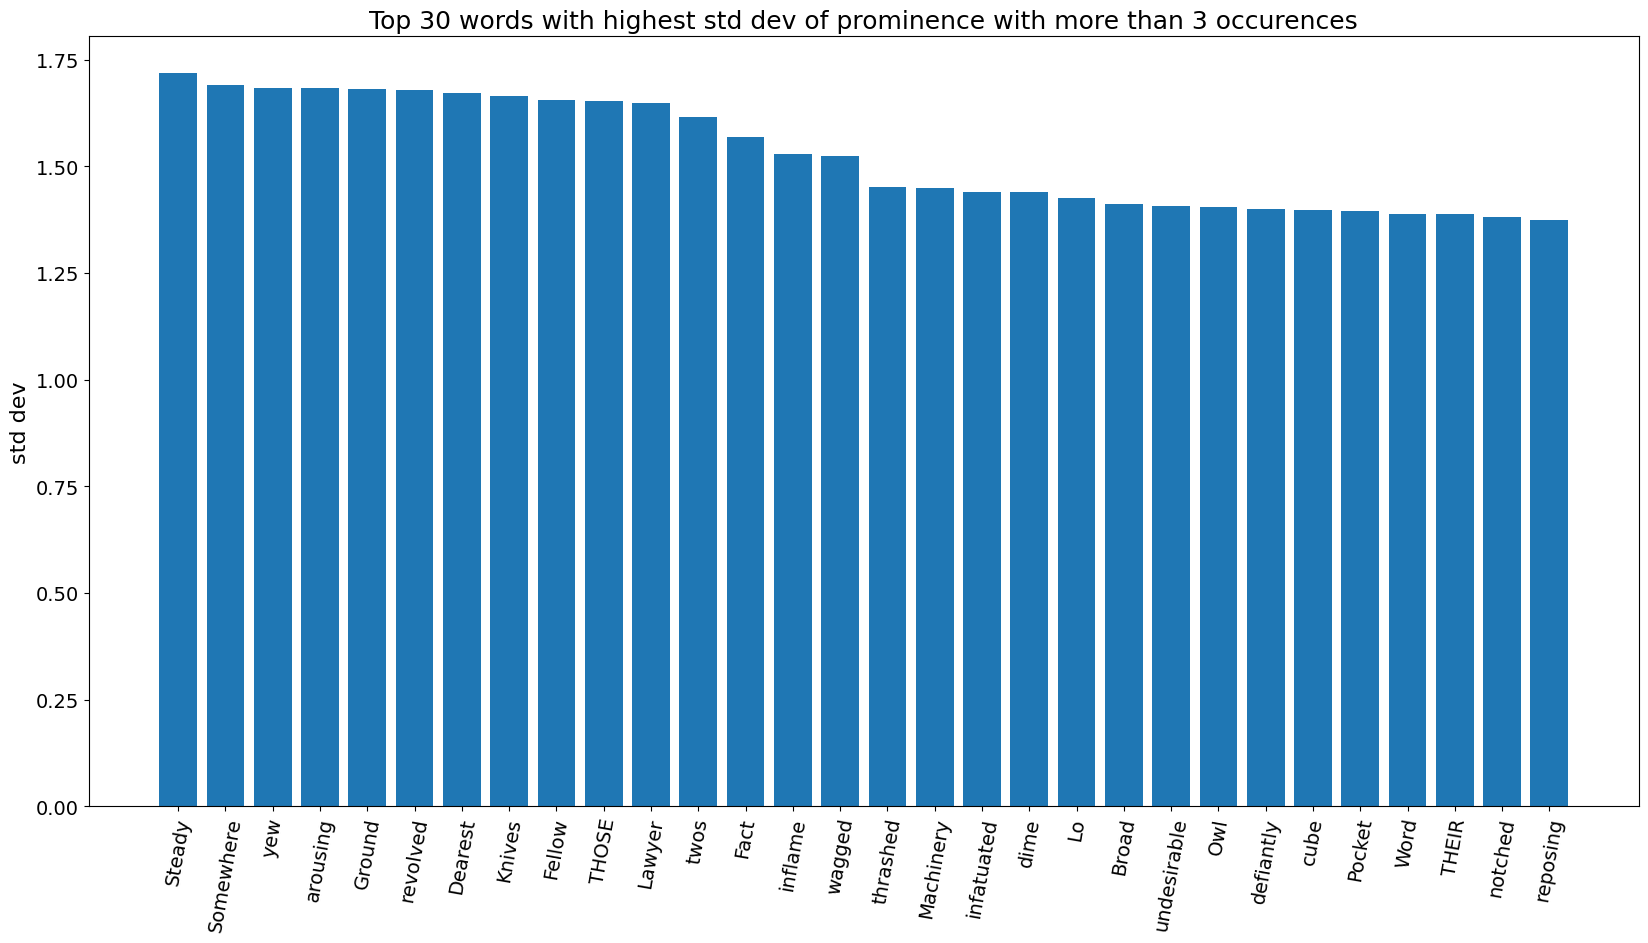

['Steady', 'Somewhere', 'yew', 'arousing', 'Ground', 'revolved', 'Dearest', 'Knives', 'Fellow', 'THOSE', 'Lawyer', 'twos', 'Fact', 'inflame', 'wagged', 'thrashed', 'Machinery', 'infatuated', 'dime', 'Lo', 'Broad', 'undesirable', 'Owl', 'defiantly', 'cube', 'Pocket', 'Word', 'THEIR', 'notched', 'reposing']


In [44]:
import matplotlib.pyplot as plt

nb_words = 30
min_occurences = 3

word_to_std_prominence_plot = {
    k: v
    for k, v in sorted(
        word_to_std_prominence_filtered.items(), key=lambda item: item[1], reverse=True
    )
    if len(word_to_prominence[k]) > min_occurences
}

plt.figure(figsize=(20, 10))
plt.bar(range(nb_words), list(word_to_std_prominence_plot.values())[:nb_words])
plt.xticks(
    range(nb_words),
    list(word_to_std_prominence_plot.keys())[:nb_words],
    rotation=80,
    fontsize=14,  # Increase fontsize for x-axis tick labels
)
plt.yticks(fontsize=14)  # Increase fontsize for y-axis tick labels
plt.title(
    f"Top {nb_words} words with highest std dev of prominence with more than {min_occurences} occurences",
    fontsize=18,  # Increase fontsize for the title
)
plt.ylabel("std dev", fontsize=16)  # Increase fontsize for the y-axis label

plt.show()

# store top 50 words in list
top_words = list(word_to_std_prominence_plot.keys())[:nb_words]
print(top_words)

In [28]:
word_to_std_prominence_plot.keys()

dict_keys(['Steady', 'Somewhere', 'yew', 'arousing', 'Ground', 'revolved', 'Dearest', 'Knives', 'Fellow', 'THOSE', 'Lawyer', 'twos', 'Fact', 'inflame', 'wagged', 'thrashed', 'Machinery', 'infatuated', 'dime', 'Lo', 'Broad', 'undesirable', 'Owl', 'defiantly', 'cube', 'Pocket', 'Word', 'THEIR', 'notched', 'reposing', 'Mole', 'connivance', 'electoral', 'typewriter', 'emerge', 'costs', 'shrieked', 'Houses', 'housing', 'Evening', 'migration', 'Religious', 'Hold', 'Private', 'Polychrome', 'balloon', 'Bullets', 'perversity', 'Name', 'Cousin', 'Dragon', 'DID', 'sourly', 'IS', 'crowbar', 'Blessed', 'Report', 'carcase', 'awed', 'salesman', 'Rest', 'oneself', 'rudely', 'gallows', 'Damosel', 'immune', 'Fool', 'YOU', 'dessert', 'Daily', 'Cold', 'gambler', 'turbine', 'Baby', 'scrubbed', 'Ion', 'Peach', 'Hard', 'sob', 'socially', 'Rule', 'WAS', 'THIS', 'Practically', 'Ego', 'versed', 'abortionist', 'Times', 'summoning', 'invoked', 'terrifying', 'Sixty', 'civilisation', 'Dare', 'tuned', 'Goat', 'vacuu

In [22]:
ranking.is_in_top_100k("yew")

True

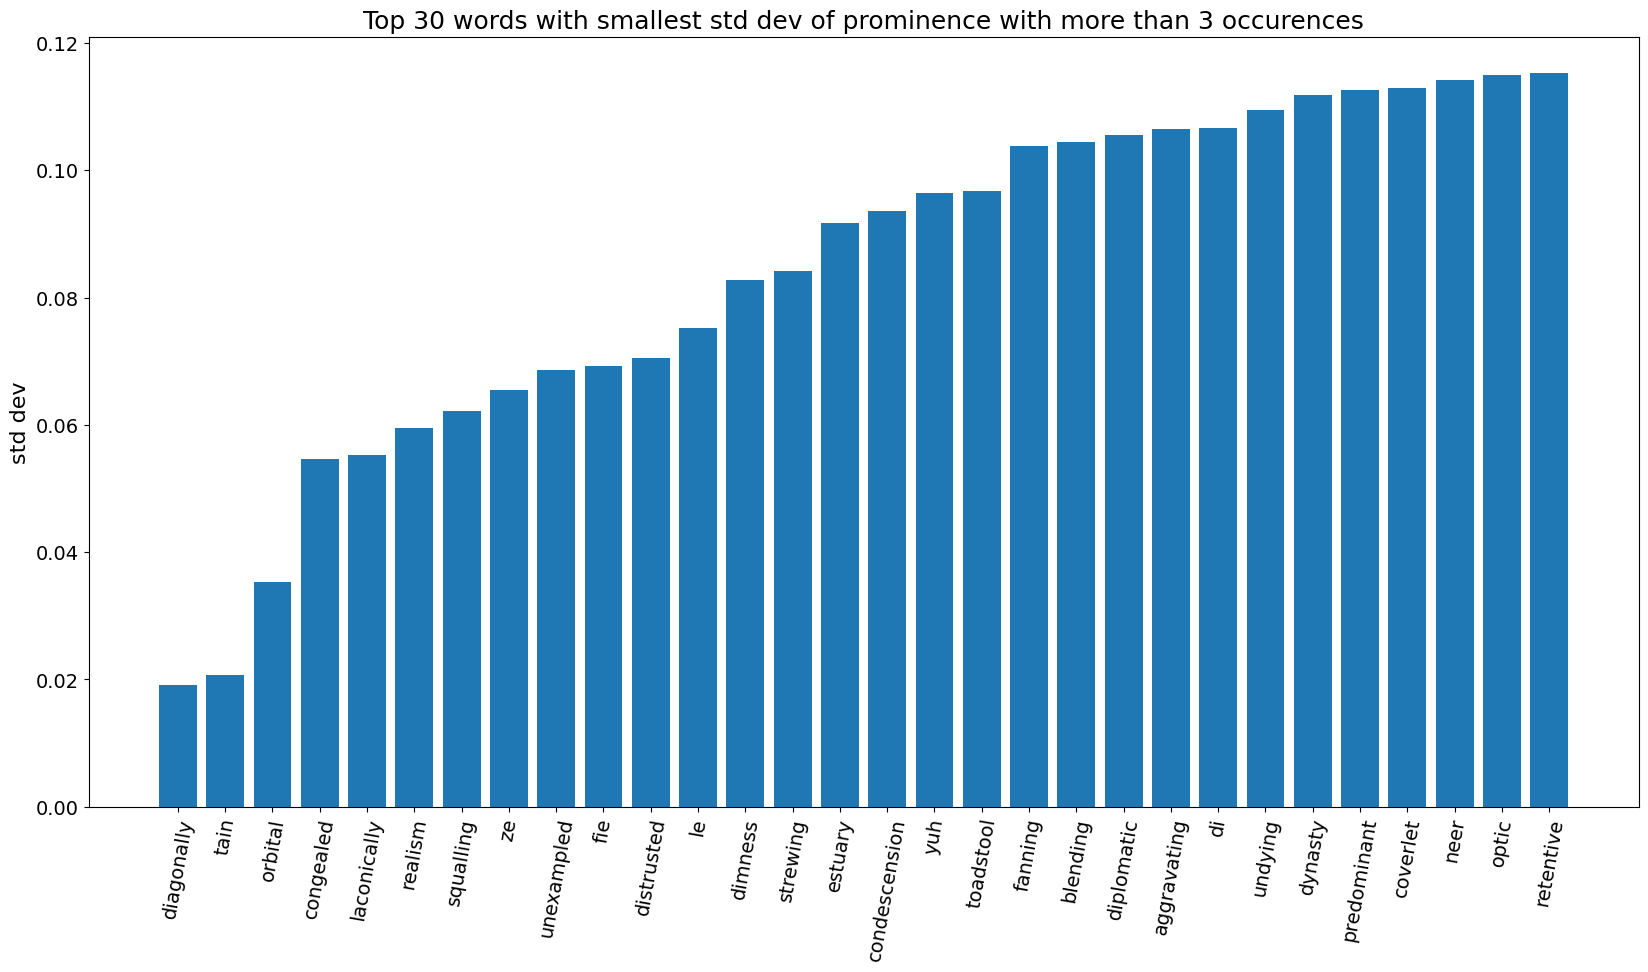

['diagonally', 'tain', 'orbital', 'congealed', 'laconically', 'realism', 'squalling', 'ze', 'unexampled', 'fie', 'distrusted', 'le', 'dimness', 'strewing', 'estuary', 'condescension', 'yuh', 'toadstool', 'fanning', 'blending', 'diplomatic', 'aggravating', 'di', 'undying', 'dynasty', 'predominant', 'coverlet', 'neer', 'optic', 'retentive']


In [23]:
import matplotlib.pyplot as plt

nb_words = 30
min_occurences = 3

word_to_std_prominence_plot = {
    k: v
    for k, v in sorted(
        word_to_std_prominence_filtered.items(),
        key=lambda item: item[1],  # Change sorting order to ascending
    )
    if len(word_to_prominence[k]) > min_occurences
}

plt.figure(figsize=(20, 10))
plt.bar(range(nb_words), list(word_to_std_prominence_plot.values())[:nb_words])
plt.xticks(
    range(nb_words),
    list(word_to_std_prominence_plot.keys())[:nb_words],
    rotation=80,
    fontsize=14,  # Increase fontsize for x-axis tick labels
)
plt.yticks(fontsize=14)  # Increase fontsize for y-axis tick labels
plt.title(
    f"Top {nb_words} words with smallest std dev of prominence with more than {min_occurences} occurences",
    fontsize=18,  # Increase fontsize for the title
)
plt.ylabel("std dev", fontsize=16)  # Increase fontsize for the y-axis label

plt.show()

# store top 30 words in list
bottom_words = list(word_to_std_prominence_plot.keys())[:nb_words]
print(bottom_words)

In [25]:
ranking.get_rank("ze")

23829

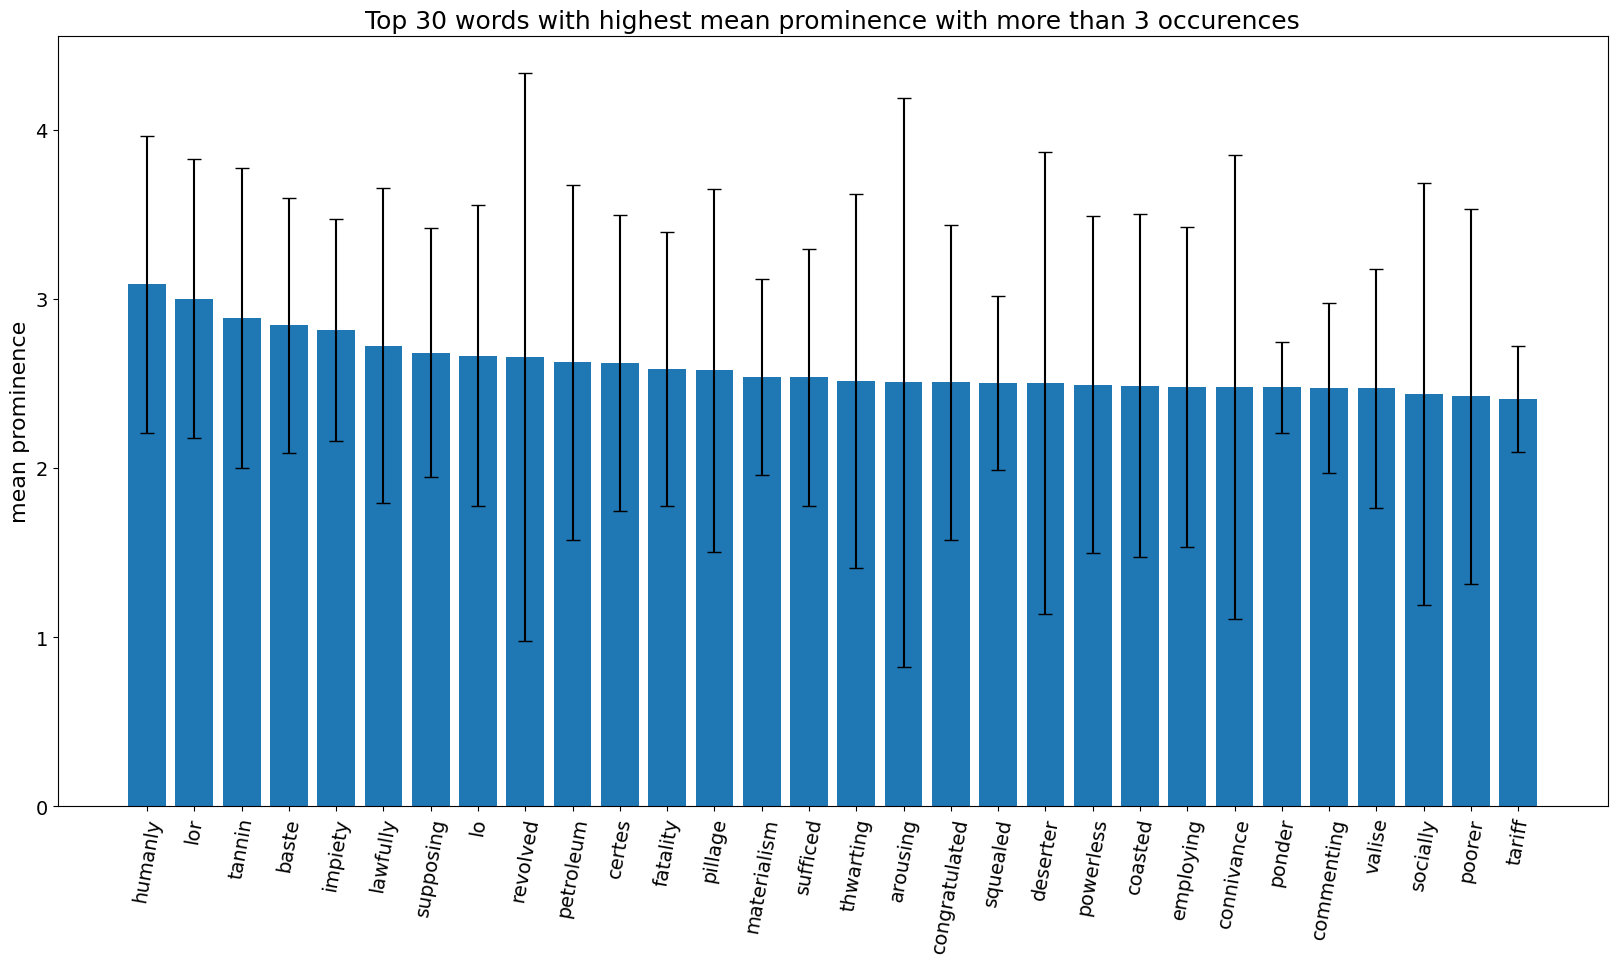

In [26]:
import matplotlib.pyplot as plt

nb_words = 30
min_occurences = 3

word_to_mean_prominence_plot = {
    k: v
    for k, v in sorted(
        word_to_mean_prominence_filtered.items(), key=lambda item: item[1], reverse=True
    )
    if len(word_to_prominence[k]) > min_occurences
}

# Extract standard deviations for selected words
word_to_std_prominence_selected = {
    k: word_to_std_prominence[k] for k in word_to_mean_prominence_plot.keys()
}
std_deviations = list(word_to_std_prominence_selected.values())[:nb_words]

plt.figure(figsize=(20, 10))
plt.bar(
    range(nb_words),
    list(word_to_mean_prominence_plot.values())[:nb_words],
    yerr=std_deviations,  # Add error bars using standard deviations
    capsize=5,  # Add cap size for the error bars
)
plt.xticks(
    range(nb_words),
    list(word_to_mean_prominence_plot.keys())[:nb_words],
    rotation=80,
    fontsize=14,  # Increase fontsize for x-axis tick labels
)
plt.yticks(fontsize=14)  # Increase fontsize for y-axis tick labels
plt.title(
    f"Top {nb_words} words with highest mean prominence with more than {min_occurences} occurences",
    fontsize=18,  # Increase fontsize for the title
)
plt.ylabel("mean prominence", fontsize=16)  # Increase fontsize for the y-axis label

plt.show()

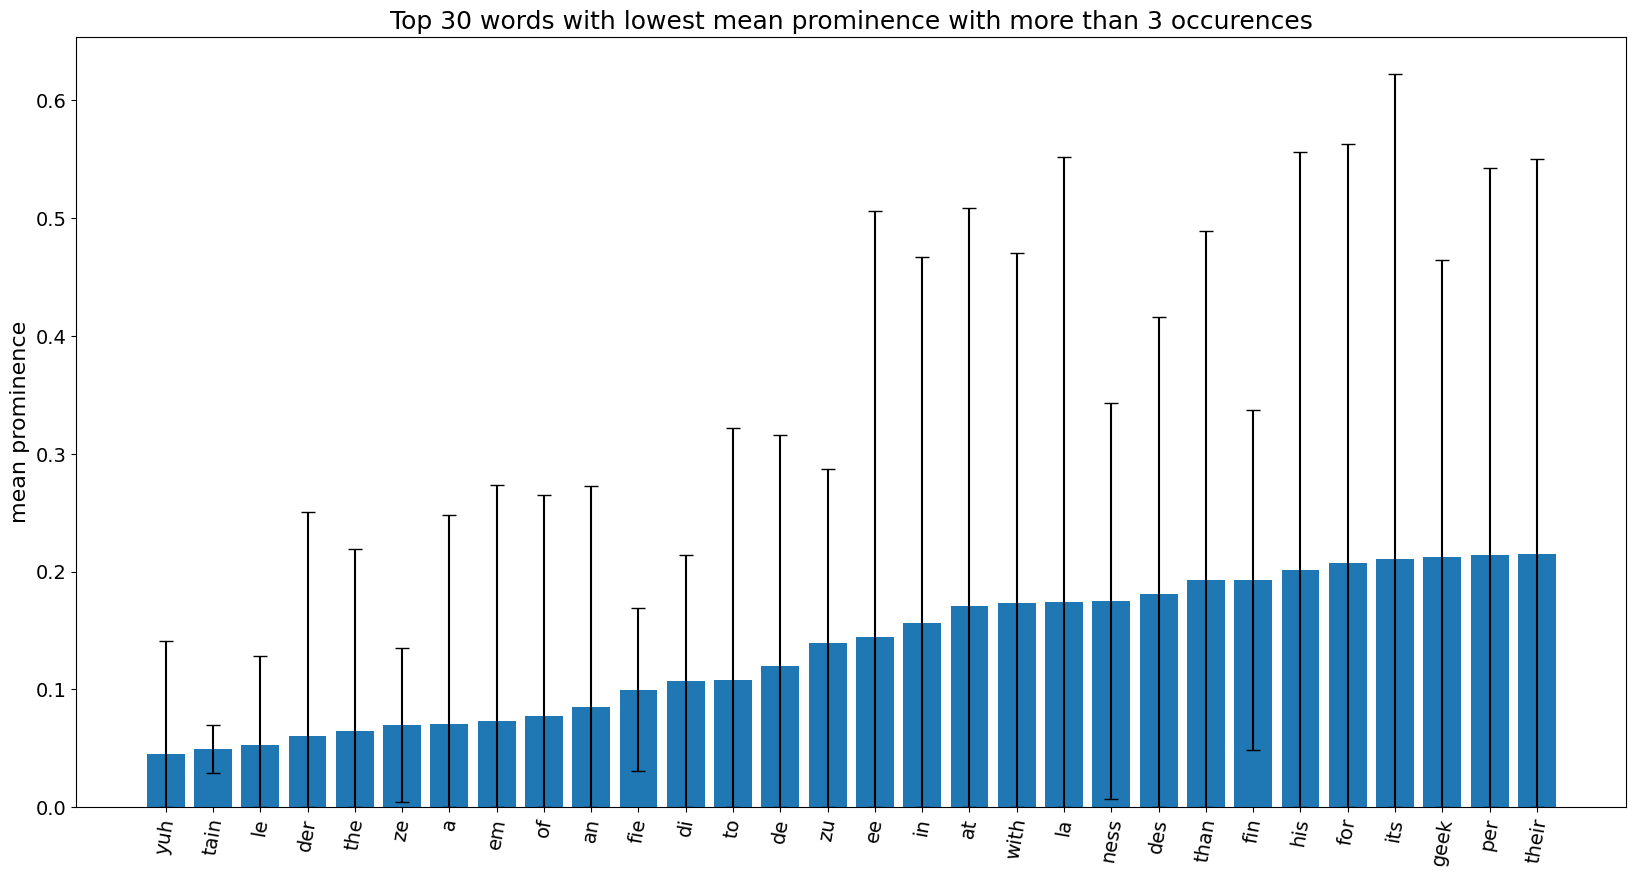

In [27]:
import matplotlib.pyplot as plt

nb_words = 30
min_occurences = 3

word_to_mean_prominence_plot = {
    k: v
    for k, v in sorted(
        word_to_mean_prominence_filtered.items(),
        key=lambda item: item[1],  # Change sorting order to ascending
    )
    if len(word_to_prominence[k]) > min_occurences
}

# Extract standard deviations for selected words
word_to_std_prominence_selected = {
    k: word_to_std_prominence[k] for k in word_to_mean_prominence_plot.keys()
}
std_deviations = list(word_to_std_prominence_selected.values())[:nb_words]
mean_values = list(word_to_mean_prominence_plot.values())[:nb_words]

# Calculate lower and upper error values separately
lower_errors = [
    min(mean_value, std_dev) for mean_value, std_dev in zip(mean_values, std_deviations)
]
upper_errors = std_deviations
errors = [lower_errors, upper_errors]

plt.figure(figsize=(20, 10))
plt.bar(
    range(nb_words),
    mean_values,
    yerr=errors,  # Pass a 2D array for lower and upper error values
    capsize=5,  # Add cap size for the error bars
)
plt.xticks(
    range(nb_words),
    list(word_to_mean_prominence_plot.keys())[:nb_words],
    rotation=80,
    fontsize=14,  # Increase fontsize for x-axis tick labels
)
plt.yticks(fontsize=14)  # Increase fontsize for y-axis tick labels
plt.title(
    f"Top {nb_words} words with lowest mean prominence with more than {min_occurences} occurences",
    fontsize=18,  # Increase fontsize for the title
)
plt.ylabel("mean prominence", fontsize=16)  # Increase fontsize for the y-axis label

plt.show()

## Create frequency plots

In [28]:
import pandas as pd

In [29]:
# Create a DataFrame with the standard deviation and frequency information for each word
data = []
for word, prominences in word_to_prominence.items():
    std = word_to_std_prominence[word]
    mean = word_to_mean_prominence[word]
    frequency = len(prominences)
    data.append([word, mean, std, frequency])

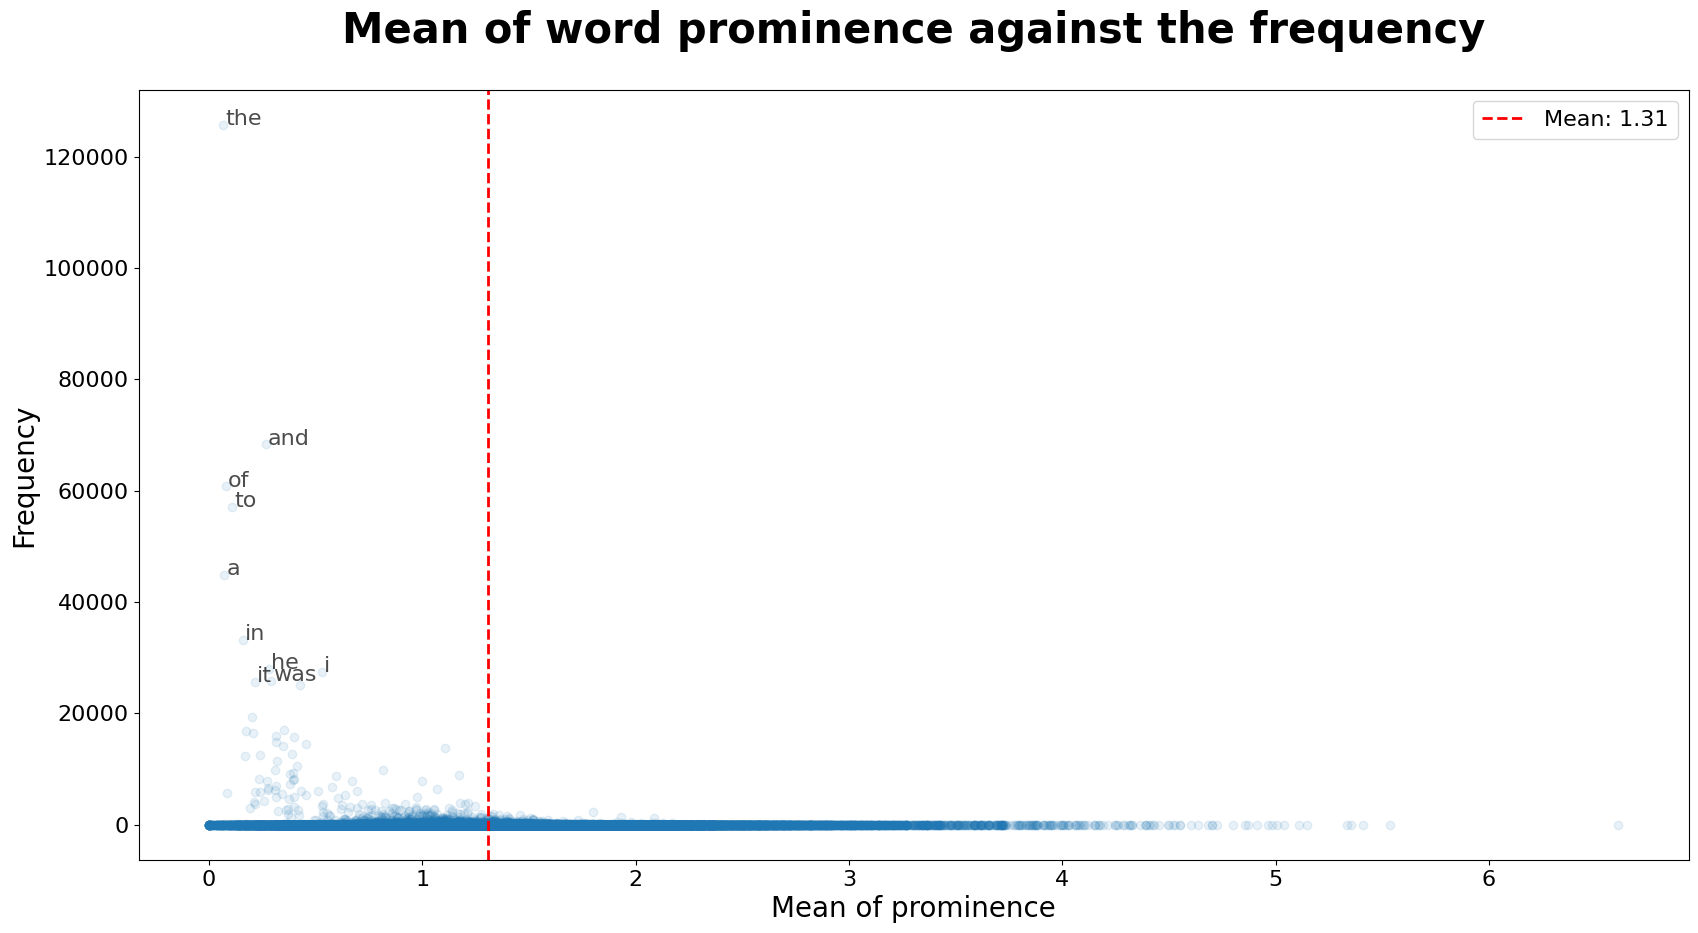

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns=["word", "mean", "std", "frequency"])
# df["log_frequency"] = np.log(df["frequency"])

fig, ax = plt.subplots(figsize=(20, 10))  # Create a figure and axis object

ax.scatter(df["mean"], df["frequency"], alpha=0.1)  # Swap the x and y values
ax.set_title(
    "Mean of word prominence against the frequency",
    fontsize=30,
    fontweight="bold",
    y=1.05,
)  # Increase font size and weight of the title
ax.set_xlabel("Mean of prominence", fontsize=20)  # Update the x-axis label
ax.set_ylabel("Frequency", fontsize=20)  # Update the y-axis label
ax.tick_params(
    axis="both", which="major", labelsize=16
)  # Increase tick label font size

# Compute the mean of the log frequency and plot it as a line
# mean_log_frequency = df["log_frequency"].mean()
mean_word = df["mean"].mean()
ax.axvline(
    x=mean_word,
    color="r",
    linestyle="--",
    label=f"Mean: {mean_word:.2f}",
    linewidth=2,  # Increase line width
)
ax.legend(fontsize=16)

# Sort the DataFrame by frequency in descending order and select the top 10 highest frequency points
top_20 = df.sort_values("frequency", ascending=False).head(10)

# Annotate the top 10 highest frequency points with their corresponding words
for index, row in top_20.iterrows():
    ax.annotate(
        row["word"],
        (row["mean"] + 0.01, row["frequency"]),
        fontsize=16,
        alpha=0.7,  # Swap the x and y values and increase font size
    )

plt.show()

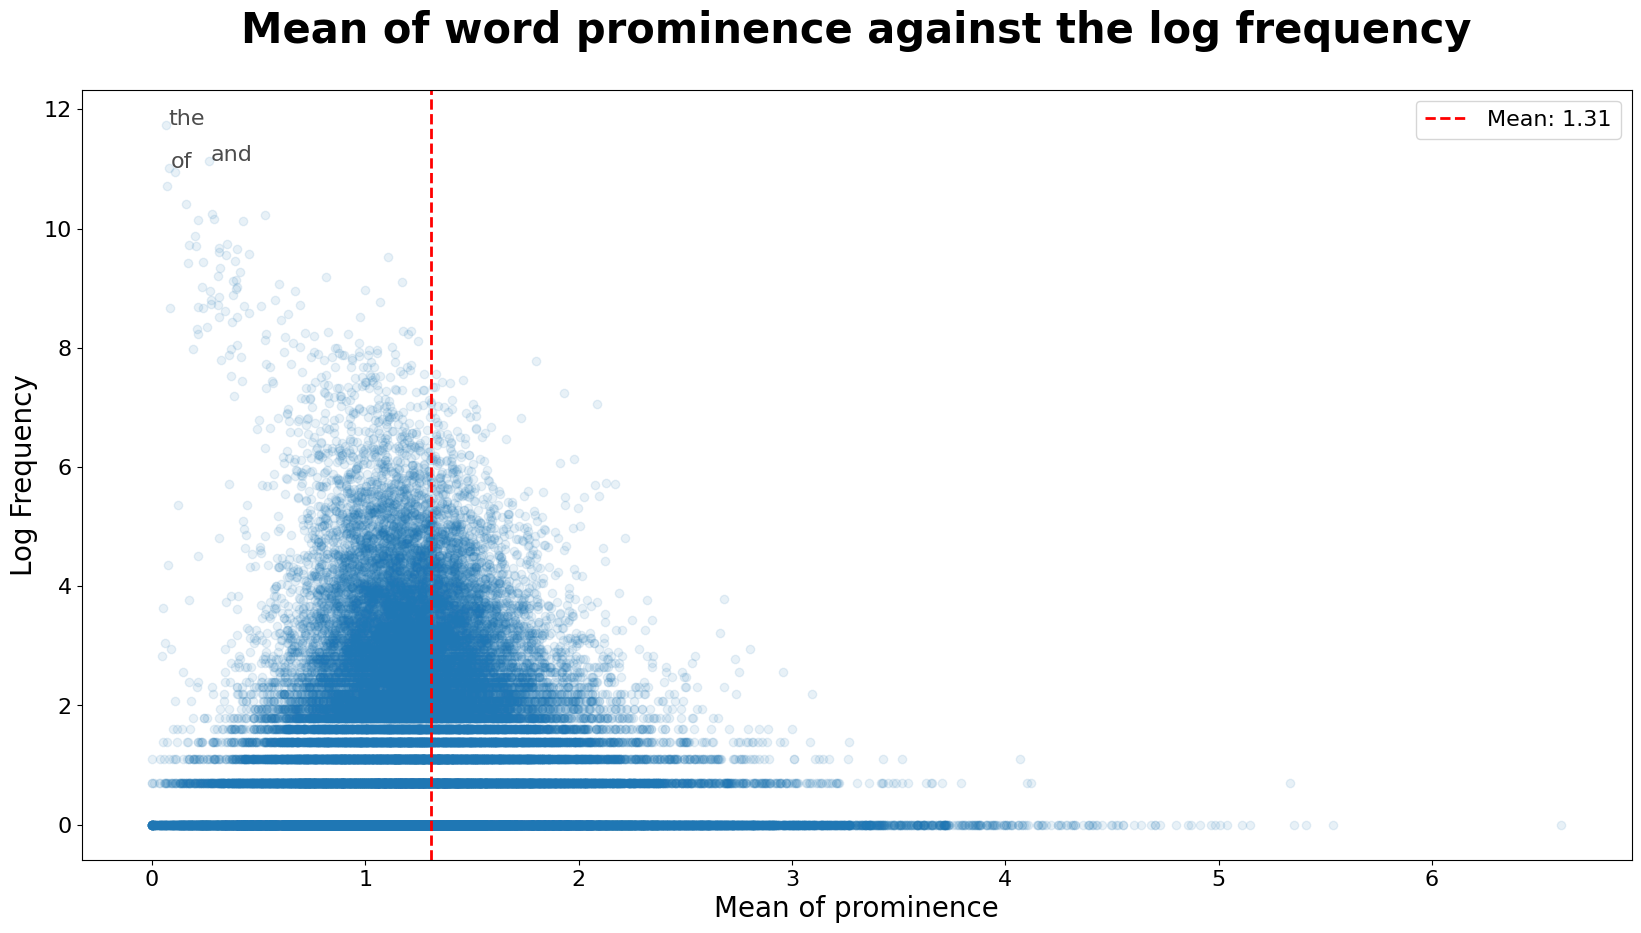

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns=["word", "mean", "std", "frequency"])
df["log_frequency"] = np.log(df["frequency"])

fig, ax = plt.subplots(figsize=(20, 10))  # Create a figure and axis object

ax.scatter(df["mean"], df["log_frequency"], alpha=0.1)  # Swap the x and y values
ax.set_title(
    "Mean of word prominence against the log frequency",
    fontsize=30,
    fontweight="bold",
    y=1.05,
)  # Increase font size and weight of the title
ax.set_xlabel("Mean of prominence", fontsize=20)  # Update the x-axis label
ax.set_ylabel("Log Frequency", fontsize=20)  # Update the y-axis label
ax.tick_params(
    axis="both", which="major", labelsize=16
)  # Increase tick label font size

# Compute the mean of the log frequency and plot it as a line
mean_word = df["mean"].mean()
ax.axvline(
    x=mean_word,
    color="r",
    linestyle="--",
    label=f"Mean: {mean_word:.2f}",
    linewidth=2,  # Increase line width
)
ax.legend(fontsize=16)

# Sort the DataFrame by frequency in descending order and select the top 10 highest frequency points
top_20 = df.sort_values("frequency", ascending=False).head(3)

# Annotate the top 10 highest frequency points with their corresponding words
for index, row in top_20.iterrows():
    ax.annotate(
        row["word"],
        (row["mean"] + 0.01, row["log_frequency"]),
        fontsize=16,
        alpha=0.7,  # Swap the x and y values and increase font size
    )

top_high_prom = df.sort_values("frequency", ascending=False).head(3)


plt.show()

Mean standard deviation of prominence: 0.39


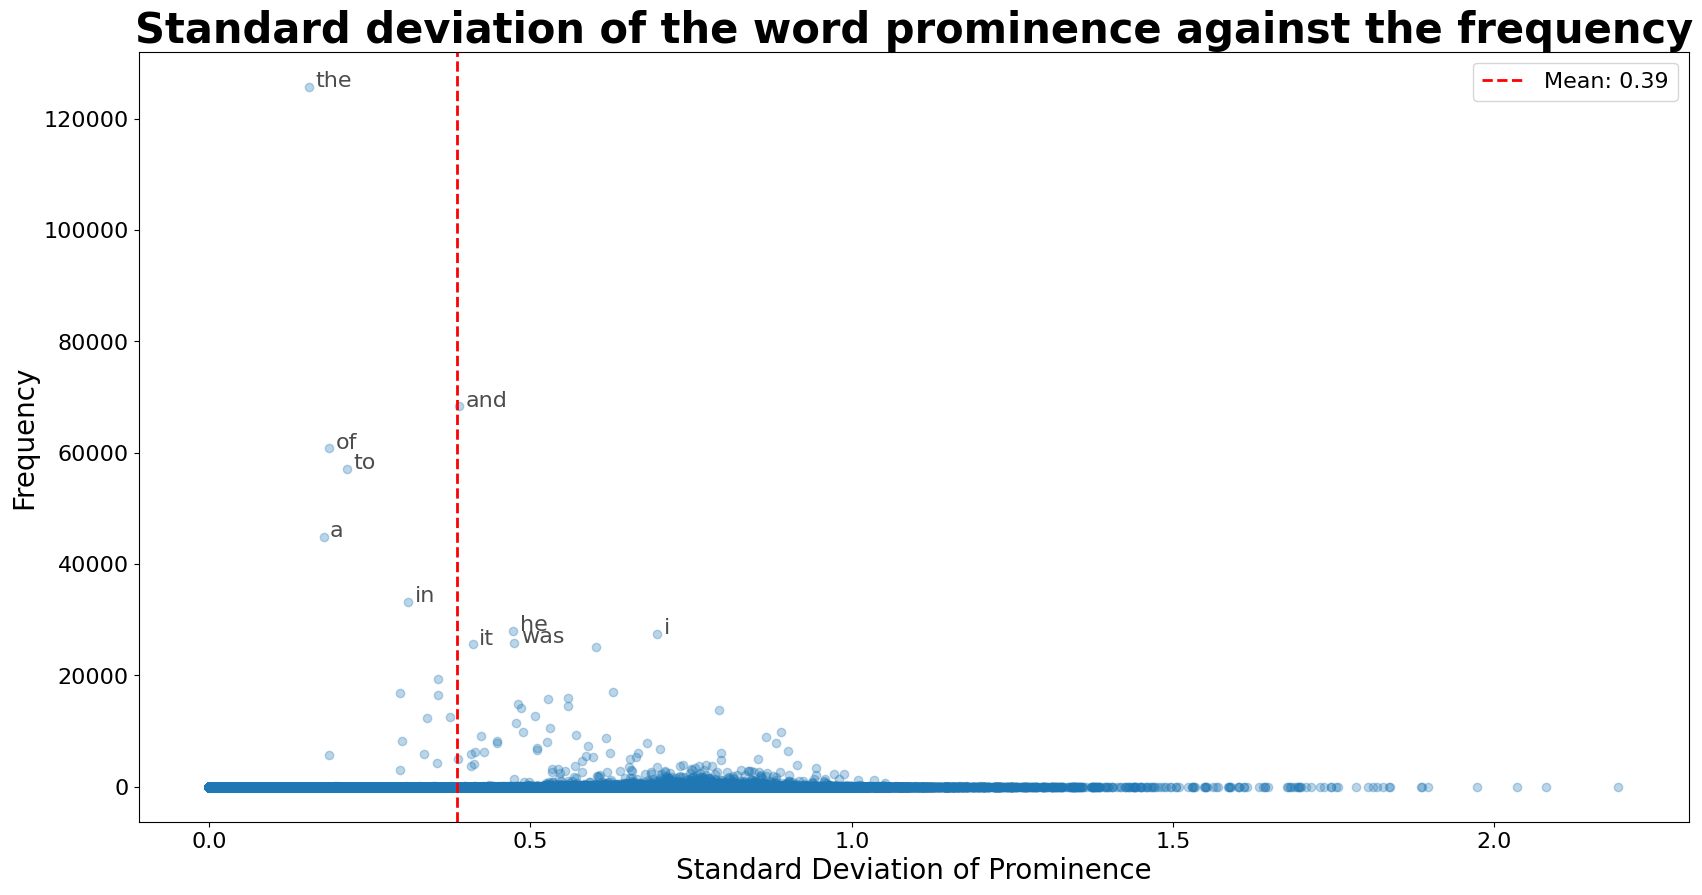

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns=["word", "mean", "std", "frequency"])
df["log_frequency"] = np.log(df["frequency"])

fig, ax = plt.subplots(figsize=(20, 10))  # Create a figure and axis object

ax.scatter(df["std"], df["frequency"], alpha=0.3)  # Transpose the axis
ax.set_title(
    "Standard deviation of the word prominence against the frequency",
    fontsize=30,
    fontweight="bold",
)  # Increase font size and weight of the title
ax.set_ylabel("Frequency", fontsize=20)  # Update the x-axis label
ax.set_xlabel(
    "Standard Deviation of Prominence", fontsize=20
)  # Update the y-axis label
ax.tick_params(
    axis="both", which="major", labelsize=16
)  # Increase tick label font size

# Compute the mean of the standard deviation and plot it as a line
mean_std = df["std"].mean()
print(f"Mean standard deviation of prominence: {mean_std:.2f}")
ax.axvline(
    x=mean_std,
    color="r",
    linestyle="--",
    label=f"Mean: {mean_std:.2f}",
    linewidth=2,
)  # Increase line width
ax.legend(fontsize=16)

# Sort the DataFrame by frequency in descending order and select the top 10 highest frequency points
top_10 = df.sort_values("frequency", ascending=False).head(10)

# Annotate the top 10 highest frequency points with their corresponding words
for index, row in top_10.iterrows():
    # print(row)
    ax.annotate(
        row["word"],
        (row["std"] + 0.01, row["frequency"]),
        fontsize=16,
        alpha=0.7,  # Swap the x and y values and increase font size
    )

plt.show()

Mean standard deviation of prominence: 0.39


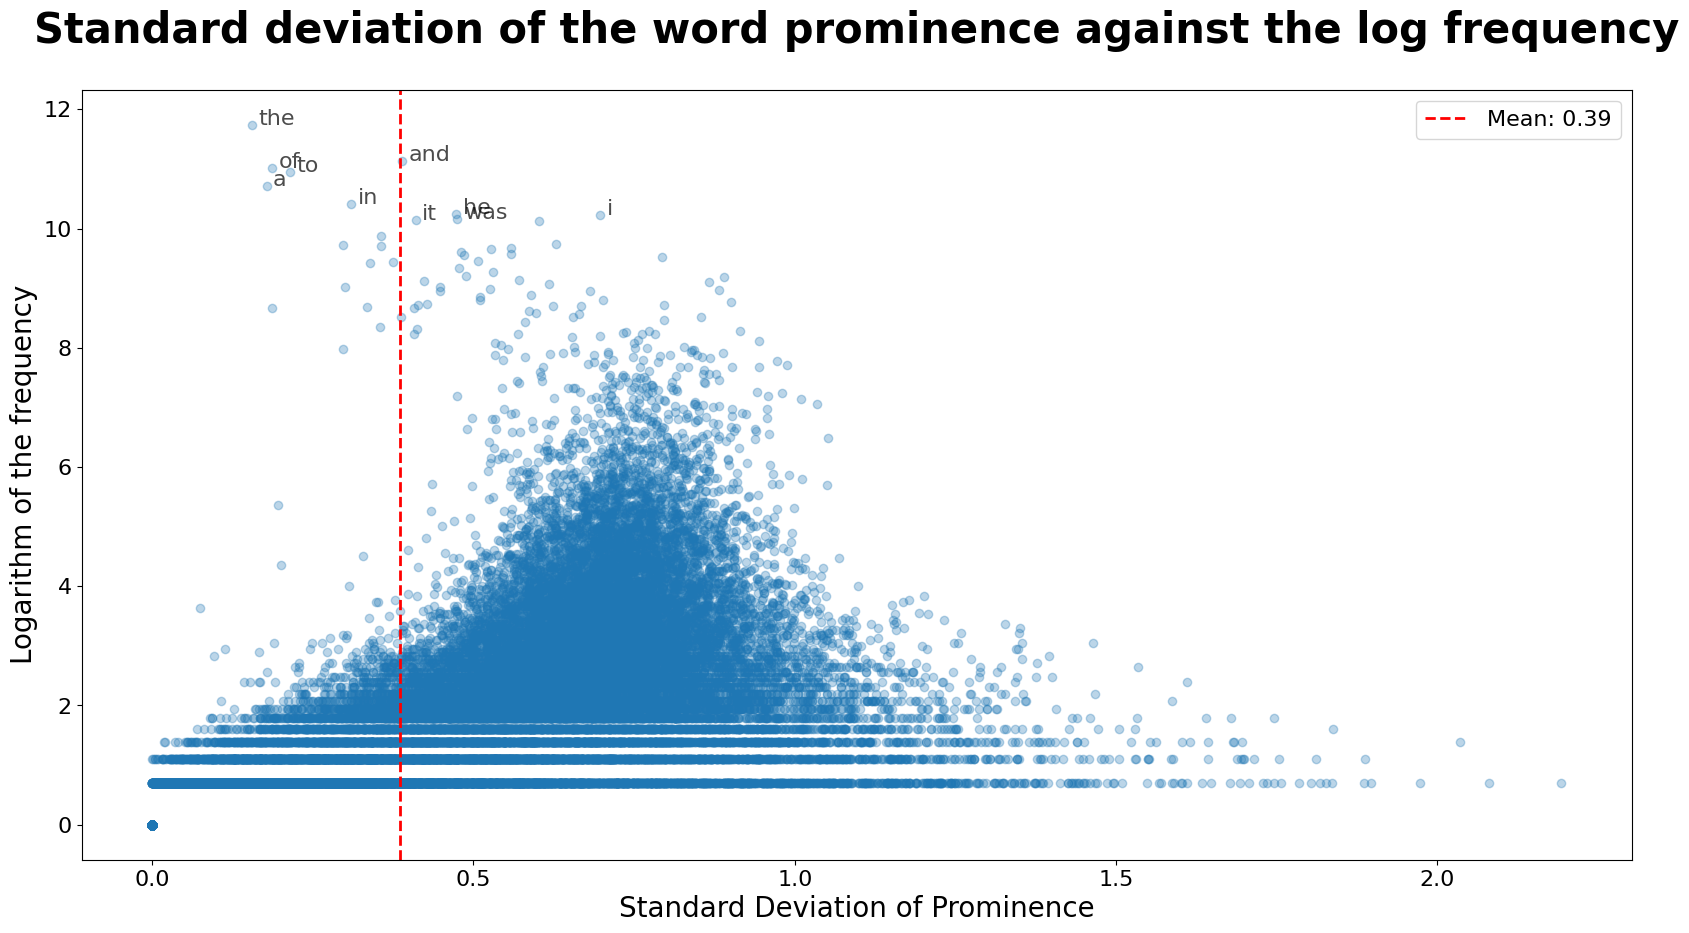

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns=["word", "mean", "std", "frequency"])
df["log_frequency"] = np.log(df["frequency"])

fig, ax = plt.subplots(figsize=(20, 10))  # Create a figure and axis object

ax.scatter(df["std"], df["log_frequency"], alpha=0.3)
ax.set_title(
    "Standard deviation of the word prominence against the log frequency",
    fontsize=30,
    fontweight="bold",
    y=1.05,
)  # Increase font size and weight of the title
ax.set_ylabel("Logarithm of the frequency", fontsize=20)  # Update the x-axis label
ax.set_xlabel(
    "Standard Deviation of Prominence", fontsize=20
)  # Update the y-axis label
ax.tick_params(
    axis="both", which="major", labelsize=16
)  # Increase tick label font size

# Compute the mean of the standard deviation and plot it as a line
mean_std = df["std"].mean()
print(f"Mean standard deviation of prominence: {mean_std:.2f}")
ax.axvline(
    x=mean_std,
    color="r",
    linestyle="--",
    label=f"Mean: {mean_std:.2f}",
    linewidth=2,
)  # Increase line width
ax.legend(fontsize=16)

# Sort the DataFrame by frequency in descending order and select the top 10 highest frequency points
top_10 = df.sort_values("frequency", ascending=False).head(10)

# Annotate the top 10 highest frequency points with their corresponding words
for index, row in top_10.iterrows():
    ax.annotate(
        row["word"],
        (row["std"] + 0.01, row["log_frequency"]),
        fontsize=16,
        alpha=0.7,  # Swap the x and y values and increase font size
    )

plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/hg/k29n8l193w76mcsdz5qf1w5h0000gn/T/ipykernel_59976/2190339282.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y=log_word_frequencies, x=std_deviations, cmap="viridis", shade=True)


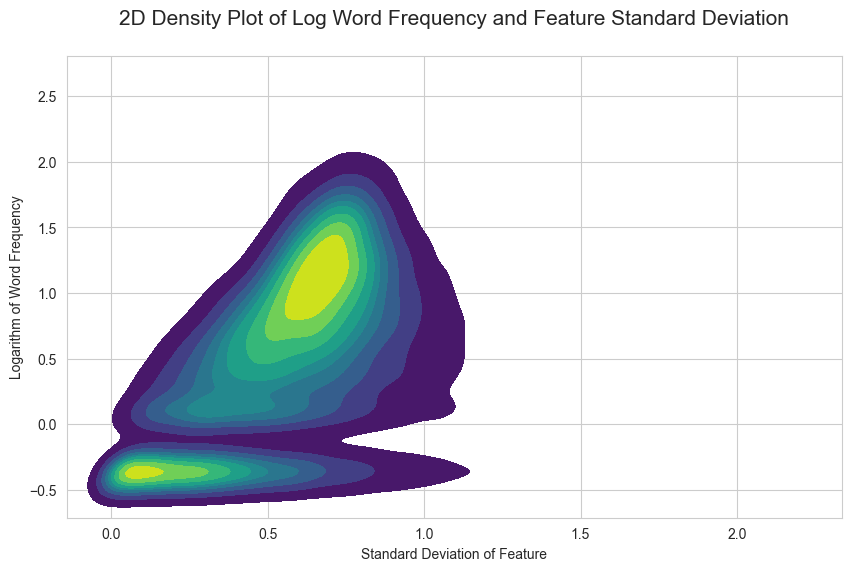

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data, columns=["word", "mean", "std", "frequency"])
df["log_frequency"] = np.log(df["frequency"])

# Example data - replace these with your actual data
word_frequencies = df["log_frequency"]
std_deviations = df["std"]

# Calculate the logarithm of word frequencies
log_word_frequencies = np.log(word_frequencies)

# Create the 2D density plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.kdeplot(y=log_word_frequencies, x=std_deviations, cmap="viridis", shade=True)

plt.ylabel("Logarithm of Word Frequency")
plt.xlabel("Standard Deviation of Feature")
plt.title(
    "2D Density Plot of Log Word Frequency and Feature Standard Deviation",
    fontsize=15,
    y=1.05,
)
plt.show()

## Create buckets for standard deviation 

In [22]:
import numpy as np
import pickle
import os

In [23]:
# Create a DataFrame with the standard deviation and frequency information for each word
data = []
for word, prominences in word_to_prominence.items():
    std = word_to_std_prominence[word]
    mean = word_to_mean_prominence[word]
    frequency = len(prominences)
    log_frequency = np.log(frequency)
    data.append([word, mean, std, frequency, log_frequency])

In [24]:
# std dev from 0 to 2 in steps of 0.5
# log frequency from 0 to 12 in steps of 2
bucket_boundaries = [
    # first row
    ((0, 0.5), (0, 2)),
    ((0.5, 1), (0, 2)),
    ((1, 1.5), (0, 2)),
    ((1.5, np.inf), (0, 2)),
    # second row
    ((0, 0.5), (2, 4)),
    ((0.5, 1), (2, 4)),
    ((1, 1.5), (2, 4)),
    ((1.5, np.inf), (2, 4)),
    # third row
    ((0, 0.5), (4, 6)),
    ((0.5, 1), (4, 6)),
    ((1, 1.5), (4, 6)),
    ((1.5, np.inf), (4, 6)),
    # fourth row
    ((0, 0.5), (6, 8)),
    ((0.5, 1), (6, 8)),
    ((1, 1.5), (6, 8)),
    ((1.5, np.inf), (6, 8)),
    # fifth row
    ((0, 0.5), (8, 10)),
    ((0.5, 1), (8, 10)),
    ((1, 1.5), (8, 10)),
    ((1.5, np.inf), (8, 10)),
    # sixth row
    ((0, 0.5), (10, 12)),
    ((0.5, 1), (10, 12)),
    ((1, 1.5), (10, 12)),
    ((1.5, np.inf), (10, 12)),
]

In [25]:
# iterate over data and insert word into the correct bucket
buckets = [{} for _ in range(len(bucket_boundaries))]

for word, mean, std, frequency, log_frequency in data:
    for i, ((std_min, std_max), (freq_min, freq_max)) in enumerate(bucket_boundaries):
        if std_min <= std < std_max and freq_min <= log_frequency < freq_max:
            buckets[i][word] = (mean, std, frequency, log_frequency)
            break

In [26]:
save_path = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/buckets/std_dev_frequency/std_dev_frequency_buckets"
# pickle the buckets
with open(os.path.join(save_path), "wb") as f:
    pickle.dump(buckets, f)

In [27]:
# load the buckets
with open(os.path.join(save_path), "rb") as f:
    buckets = pickle.load(f)
buckets[20]

{'of': (0.07763124711924672, 0.18707549740471363, 60748, 11.01448943885016),
 'he': (0.2789730029321319, 0.47298752737455146, 27966, 10.238744765600796),
 'to': (0.1078069754825613, 0.21409530083457676, 57143, 10.95331217703168),
 'the': (0.06440348728065291, 0.15486595761814873, 125714, 11.74176476466922),
 'a': (0.07020239157594146, 0.17812565638453778, 44824, 10.71049898924512),
 'and': (0.2655453653680034, 0.3886525437509255, 68301, 11.131679686740132),
 'was': (0.29177297192642787, 0.4747293766990219, 25825, 10.159098293987839),
 'in': (0.15671202674618234, 0.3100992909448557, 33201, 10.410335274932896),
 'it': (0.21558956712157354, 0.4099633876342898, 25573, 10.149292386393418)}

In [28]:
# visualize how many elements per bucket
for i, bucket in enumerate(buckets):
    print(f"Bucket {i}: {len(bucket)}")

Bucket 0: 24002
Bucket 1: 6482
Bucket 2: 824
Bucket 3: 62
Bucket 4: 1384
Bucket 5: 8296
Bucket 6: 379
Bucket 7: 3
Bucket 8: 27
Bucket 9: 2634
Bucket 10: 13
Bucket 11: 0
Bucket 12: 4
Bucket 13: 408
Bucket 14: 3
Bucket 15: 0
Bucket 16: 22
Bucket 17: 45
Bucket 18: 0
Bucket 19: 0
Bucket 20: 9
Bucket 21: 2
Bucket 22: 0
Bucket 23: 0


## Now take BERT predictions into account 

In [29]:
file = "/Users/lukas/Desktop/projects/MIT/results_bert_regression.txt"

In [30]:
def read_data(input_string):
    data = []
    lines = input_string.strip().split("\n")

    for line in lines:
        if not line:
            continue
        word, true_label, predicted_label = line.split("\t")
        data.append(
            {
                "word": word,
                "true_label": float(true_label),
                "predicted_label": float(predicted_label),
            }
        )

    return data

In [31]:
data = read_data(open(file).read())

In [32]:
words = [d["word"] for d in data]
true_labels = [d["true_label"] for d in data]
predicted_labels = [d["predicted_label"] for d in data]

In [33]:
# compute mse
errors = [np.abs(true_labels[i] - predicted_labels[i]) for i in range(len(true_labels))]
mse = [np.square(true_labels[i] - predicted_labels[i]) for i in range(len(true_labels))]

In [34]:
np.mean(errors), np.mean(mse)

(0.8026957969252857, 1.412632292874996)

In [35]:
# compute the average error per word
word_to_error = {}
for i in range(len(data)):
    word = words[i]
    error = errors[i]
    if word not in word_to_error:
        word_to_error[word] = []
    word_to_error[word].append(error)

word_to_avg_error = {}
for word in word_to_error.keys():
    word_to_avg_error[word] = np.mean(word_to_error[word])

In [36]:
# for each word to avg error, find the bucket it belongs to and add the error to the bucket
bucket_errors = [[] for _ in range(len(buckets))]
for word, error in word_to_avg_error.items():
    for i, bucket in enumerate(buckets):
        if word in bucket:
            bucket_errors[i].append(error)
            break

# compute the average error per bucket
bucket_to_avg_error = {}
for i, bucket in enumerate(buckets):
    bucket_to_avg_error[i] = np.mean(bucket_errors[i])

/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
# for each word to avg error, find the bucket it belongs to and count the number of samples in each bucket
bucket_counts = [len(bucket_errors[i]) for i in range(len(buckets))]
bucket_counts

[1282,
 792,
 60,
 5,
 464,
 3503,
 86,
 1,
 22,
 2325,
 9,
 0,
 4,
 401,
 2,
 0,
 22,
 45,
 0,
 0,
 9,
 2,
 0,
 0]

[0, 0, 2, 9, 0, 0, 45, 22, 0, 2, 401, 4, 0, 9, 2325, 22, 1, 86, 3503, 464, 5, 60, 792, 1282]
[[   0    0    2    9]
 [   0    0   45   22]
 [   0    2  401    4]
 [   0    9 2325   22]
 [   1   86 3503  464]
 [   5   60  792 1282]]


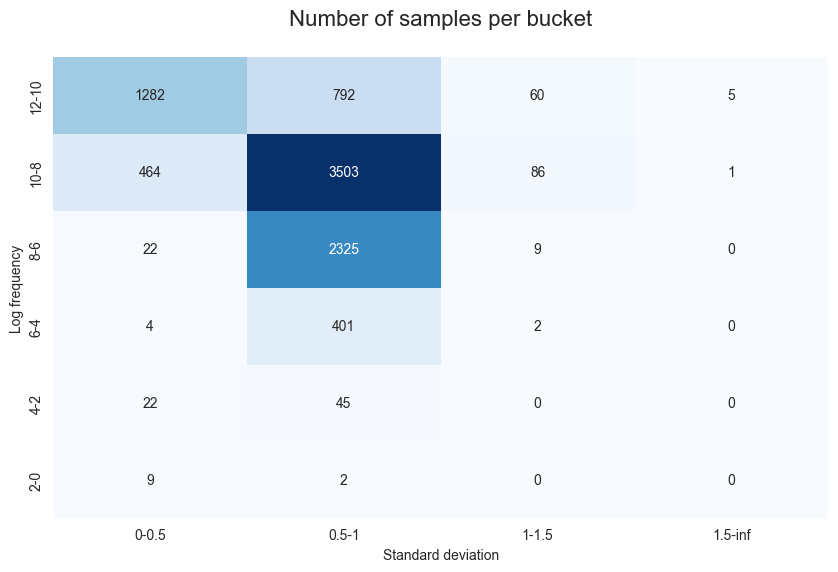

In [38]:
bucket_counts_rev = bucket_counts
bucket_counts_rev = bucket_counts[::-1]
print(bucket_counts_rev)
bucket_counts_rev = np.reshape(bucket_counts_rev, (6, 4))
print(bucket_counts_rev)

plt.figure(figsize=(10, 6))
sns.heatmap(
    np.array(bucket_counts).reshape(6, 4),
    cmap="Blues",
    annot=True,
    fmt="d",
    cbar=False,
    xticklabels=["0-0.5", "0.5-1", "1-1.5", "1.5-inf"],
    yticklabels=["12-10", "10-8", "8-6", "6-4", "4-2", "2-0"],
)
plt.xlabel("Standard deviation")
plt.ylabel("Log frequency")
plt.title("Number of samples per bucket", y=1.05, fontsize=16)
plt.show()

In [39]:
bucket_avg_errors = list(bucket_to_avg_error.values())
bucket_avg_errors

[1.0240395549120178,
 1.0852943333417842,
 1.1479159331880509,
 0.8353768706321716,
 1.0002478501315983,
 1.0653083141059372,
 1.3724223770759518,
 0.9517936110496521,
 0.790577147916763,
 1.0214608410285448,
 1.5054732458750026,
 nan,
 0.5805522227196835,
 0.9001508802290935,
 1.5695909621543251,
 nan,
 0.5737456934514373,
 0.7017376042064974,
 nan,
 nan,
 0.5347164806504792,
 0.48159791004381464,
 nan,
 nan]

In [40]:
# reshape the bucket errors into a 4x6 matrix
bucket_avg_errors_rev = bucket_avg_errors
bucket_avg_errors_rev = bucket_avg_errors[::-1]
bucket_avg_errors_rev = np.array(bucket_avg_errors_rev).reshape(6, 4)
bucket_avg_errors_rev

# flip columns
bucket_avg_errors_rev = bucket_avg_errors_rev[:, ::-1]
bucket_avg_errors_rev

array([[0.53471648, 0.48159791,        nan,        nan],
       [0.57374569, 0.7017376 ,        nan,        nan],
       [0.58055222, 0.90015088, 1.56959096,        nan],
       [0.79057715, 1.02146084, 1.50547325,        nan],
       [1.00024785, 1.06530831, 1.37242238, 0.95179361],
       [1.02403955, 1.08529433, 1.14791593, 0.83537687]])

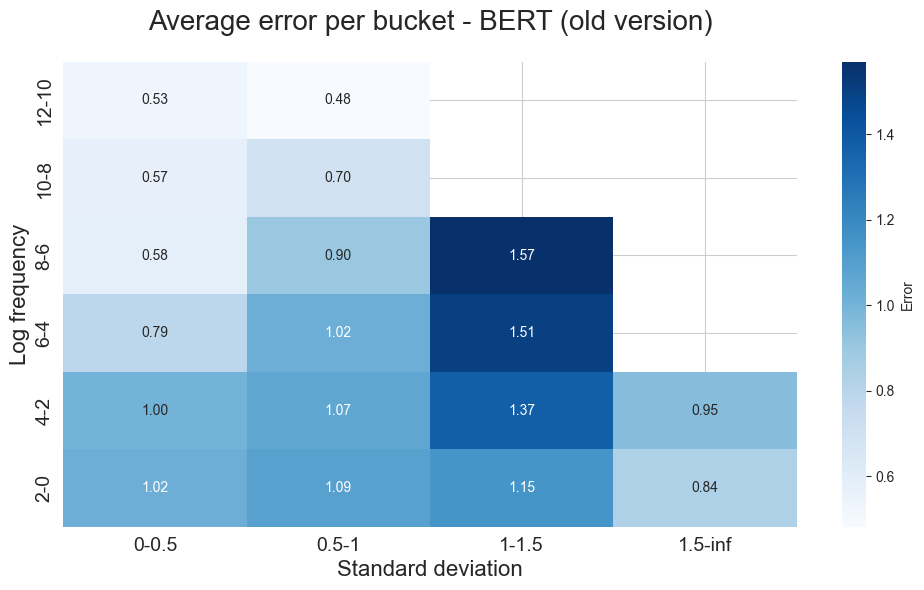

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    bucket_avg_errors_rev,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar=True,
    cbar_kws={"label": "Error", "orientation": "vertical", "pad": 0.05},
    xticklabels=["0-0.5", "0.5-1", "1-1.5", "1.5-inf"],
    yticklabels=["12-10", "10-8", "8-6", "6-4", "4-2", "2-0"],
    ax=ax,
)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.xlabel("Standard deviation", fontsize=16)
plt.ylabel("Log frequency", fontsize=16)
plt.title("Average error per bucket - BERT (old version)", y=1.05, fontsize=20)
plt.tight_layout()
plt.show()